In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, glob, time, copy, random, zipfile
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
    
classes = list()
with open('./2021VRDL_HW1_datasets/classes.txt') as f:
   for line in f:
       # For Python3, use print(line)
        classes.append(line[:-1])
        if 'str' in line:
            break
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.empty_cache()


In [2]:
torch.__version__
train_dir = './2021VRDL_HW1_datasets/training_images'
test_dir = './2021VRDL_HW1_datasets/training_images'

os.listdir(train_dir)[:5]
os.listdir(test_dir)[:5]

['0003.jpg', '0008.jpg', '0010.jpg', '0011.jpg', '0012.jpg']

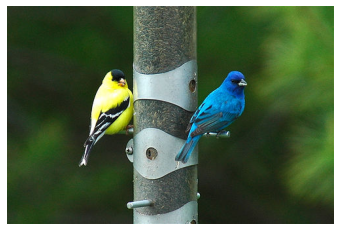

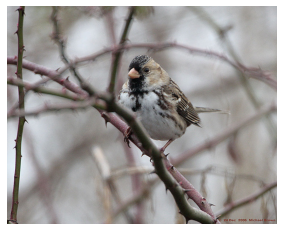

In [3]:
train_list = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
img = Image.open(train_list[2])
plt.imshow(img)
plt.axis('off')
plt.show()
img = Image.open(test_list[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
class ImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
               transforms.Resize(255),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [5]:
# trasform
class newImageTransform():
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(256),
                   torchvision.transforms.RandomOrder([
                   torchvision.transforms.RandomCrop((256, 256)),
                   torchvision.transforms.RandomHorizontalFlip(),
                   torchvision.transforms.RandomVerticalFlip()
                ]),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(256),
                torchvision.transforms.CenterCrop((256, 256)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [6]:
# build label_dict
label_dict = {}
with open('./2021VRDL_HW1_datasets/training_labels.txt', 'r', encoding='utf-8-sig') as R:
    lines = R.readlines()
for line in lines:
    line = line.split('\n')[0].split(" ")
    label_dict[line[0]] = (line[1])
label_dict

{'4283.jpg': '115.Brewer_Sparrow',
 '3982.jpg': '162.Canada_Warbler',
 '5836.jpg': '144.Common_Tern',
 '5980.jpg': '008.Rhinoceros_Auklet',
 '4168.jpg': '161.Blue_winged_Warbler',
 '2352.jpg': '061.Heermann_Gull',
 '0511.jpg': '038.Great_Crested_Flycatcher',
 '4492.jpg': '147.Least_Tern',
 '1254.jpg': '132.White_crowned_Sparrow',
 '2792.jpg': '177.Prothonotary_Warbler',
 '1171.jpg': '098.Scott_Oriole',
 '3741.jpg': '062.Herring_Gull',
 '5751.jpg': '030.Fish_Crow',
 '3819.jpg': '081.Pied_Kingfisher',
 '0082.jpg': '041.Scissor_tailed_Flycatcher',
 '4532.jpg': '102.Western_Wood_Pewee',
 '2452.jpg': '091.Mockingbird',
 '5231.jpg': '101.White_Pelican',
 '2412.jpg': '171.Myrtle_Warbler',
 '1183.jpg': '091.Mockingbird',
 '1969.jpg': '097.Orchard_Oriole',
 '2772.jpg': '045.Northern_Fulmar',
 '5952.jpg': '121.Grasshopper_Sparrow',
 '2466.jpg': '164.Cerulean_Warbler',
 '5964.jpg': '160.Black_throated_Blue_Warbler',
 '5558.jpg': '035.Purple_Finch',
 '1448.jpg': '169.Magnolia_Warbler',
 '1338.jpg'

In [7]:
# spilt train data and test data 
train_set = train_list
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size])
print('Train data set:', len(train_set))
test_list = valid_set
print('Valid data set:', len(valid_set))

Train data set: 2400
Valid data set: 600


In [8]:
# Dataset
class PartDataset(data.Dataset):
    
    def __init__(self, label_dict, file_list, transform=None, phase='train'):
        self.label_dict = label_dict
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        
        img_transformed = self.transform(img, self.phase)
        # Get Label
        label = self.label_dict[img_path.split('\\')[-1]]
        return img_transformed, label

In [9]:
# setting
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
# mean = (0.5, 0.5, 0.5)
# std = (0.5, 0.5, 0.5)

batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
train_dataset = PartDataset(label_dict, train_list, transform=newImageTransform(size, mean, std), phase='train')
test_dataset = PartDataset(label_dict, test_list, transform=newImageTransform(size, mean, std), phase='test')


In [11]:
# DataLoader
train_dataloader = data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=16, shuffle=False)

dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}

# Operation Check
print('Operation Check')
batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

Operation Check
torch.Size([16, 3, 256, 256])
('126.Nelson_Sharp_tailed_Sparrow', '008.Rhinoceros_Auklet', '006.Least_Auklet', '082.Ringed_Kingfisher', '156.White_eyed_Vireo', '179.Tennessee_Warbler', '190.Red_cockaded_Woodpecker', '184.Louisiana_Waterthrush', '188.Pileated_Woodpecker', '034.Gray_crowned_Rosy_Finch', '112.Great_Grey_Shrike', '009.Brewer_Blackbird', '150.Sage_Thrasher', '027.Shiny_Cowbird', '176.Prairie_Warbler', '021.Eastern_Towhee')


In [12]:
# build net with pretrain modal
pretrained = True
num_classes = 200


net =models.resnet50( pretrained=pretrained).to(device)
num_ftrs = net.fc.in_features
net.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 1024),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)
# num_ftrs = net.fc.in_features
# net.fc = nn.Linear(num_ftrs, 200)

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)


In [14]:
import time
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'test']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
#                 print(type(labels))
               
                labelsArr = []
                
                for tmplabel in (labels):
#                     print(tmplabel)
                    labelsArr.append(int(tmplabel.split(".")[0])-1)
                labels = torch.tensor(labelsArr).to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
          
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                print(time.time())
                torch.save(net.state_dict(), 'best_checkpoint_last.pth')
                
                xtrain.append(epoch + 1)
                ytrainAcc.append(epoch_acc)
                ytrain.append(epoch_loss)
            else:
                xtest.append(epoch + 1)
                ytestAcc.append(epoch_acc)
                ytest.append(epoch_loss)
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [15]:
import matplotlib.pyplot as plt
xtrain=[]
ytrainAcc=[]
ytrain=[]

xtest=[]
ytestAcc=[]
ytest=[]

In [16]:
# train
num_epoch = 60
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)



Epoch 1/1
--------------------


  0%|          | 0/188 [00:00<?, ?it/s]

train Loss: 5.3140 Acc: 0.0103


  0%|          | 0/38 [00:00<?, ?it/s]

test Loss: 5.0387 Acc: 0.0767
1635525099.8999736
Training complete in 4m 6s
Best val Acc: 0.076667


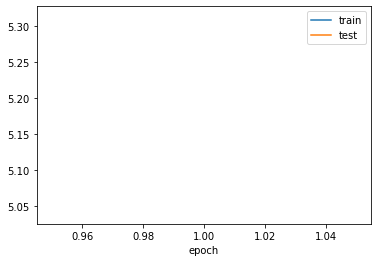

In [17]:
# check  convergence
plt.plot(xtrain, ytrain, label = "train")
plt.plot(xtest, ytest, label = "test")
plt.xlabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()

In [18]:
# save the checkpoint
checkpoint = net.load_state_dict(torch.load('./best_checkpoint_last.pth'))
net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# load the checkpoint
testorder = list()
with open('./2021VRDL_HW1_datasets/testing_img_order.txt') as f:
   for line in f:
       # For Python3, use print(line)
        testorder.append(line.split('\n')[0])
        if 'str' in line:
            break
print(testorder)

['4282.jpg', '1704.jpg', '2333.jpg', '2320.jpg', '1680.jpg', '2120.jpg', '3291.jpg', '0393.jpg', '0160.jpg', '3041.jpg', '1374.jpg', '5388.jpg', '3683.jpg', '1052.jpg', '1454.jpg', '2560.jpg', '4124.jpg', '1334.jpg', '5710.jpg', '5256.jpg', '2398.jpg', '5860.jpg', '5230.jpg', '3131.jpg', '2941.jpg', '2696.jpg', '5137.jpg', '5550.jpg', '0513.jpg', '0467.jpg', '0286.jpg', '4749.jpg', '2386.jpg', '2238.jpg', '5545.jpg', '1296.jpg', '4366.jpg', '2404.jpg', '4535.jpg', '1238.jpg', '0836.jpg', '2469.jpg', '2375.jpg', '3204.jpg', '0644.jpg', '4568.jpg', '1758.jpg', '2348.jpg', '4919.jpg', '1868.jpg', '5336.jpg', '3737.jpg', '4419.jpg', '0814.jpg', '5871.jpg', '3317.jpg', '3976.jpg', '4075.jpg', '4766.jpg', '3445.jpg', '0869.jpg', '2005.jpg', '3705.jpg', '0091.jpg', '3630.jpg', '2309.jpg', '2974.jpg', '1601.jpg', '3901.jpg', '5428.jpg', '0383.jpg', '0864.jpg', '1381.jpg', '5874.jpg', '4092.jpg', '5367.jpg', '2315.jpg', '2172.jpg', '2363.jpg', '3648.jpg', '4946.jpg', '2336.jpg', '0933.jpg', '25

In [20]:
def img_transform(img_rgb, transform=None):
    """
    将数据转换为模型读取的形式
    :param img_rgb: PIL Image
    :param transform: torchvision.transform
    :return: tensor
    """

    if transform is None:
        raise ValueError("找不到transform！必须有transform对img进行处理")

    img_t = transform(img_rgb)
    return img_t

In [21]:
# predict and make file
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
# norm_mean = [0.5, 0.5, 0.5]
# norm_std = [0.5, 0.5, 0.5]

inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

import time
path = 'answer.txt'
f = open(path, 'w')

with torch.no_grad():
#         print(classes)
        for  img_name in testorder:
            print(img_name)
            path_img ='./2021VRDL_HW1_datasets/testing_images/'+img_name
            img_rgb = Image.open(path_img).convert('RGB')

            img_tensor = img_transform(img_rgb, inference_transform)
            img_tensor.unsqueeze_(0)
            img_tensor = img_tensor.to(device)
            
            # step 3/4 : tensor --> vector
            time_tic = time.time()
            outputs = net(img_tensor)
            time_toc = time.time()
            
             # step 4/4 : visualization
            _, pred_int = torch.max(outputs.data, 1)
#             print(int(pred_int))
            if(pred_int >= 200):
                pred_int=0
                print(int(pred_int))
            
#             print(classes[int(pred_int)])
            pred_str = classes[int(pred_int)]
        
            f.write(img_name)           
            f.write(' ')
            f.write(pred_str)  
            f.write('\n')
            
f.close()

4282.jpg
1704.jpg
2333.jpg
2320.jpg
1680.jpg
2120.jpg
3291.jpg
0393.jpg
0160.jpg
3041.jpg
1374.jpg
5388.jpg
3683.jpg
1052.jpg
1454.jpg
2560.jpg
4124.jpg
1334.jpg
5710.jpg
5256.jpg
2398.jpg
5860.jpg
5230.jpg
3131.jpg
2941.jpg
2696.jpg
5137.jpg
5550.jpg
0513.jpg
0467.jpg
0286.jpg
4749.jpg
2386.jpg
2238.jpg
5545.jpg
1296.jpg
4366.jpg
2404.jpg
4535.jpg
1238.jpg
0836.jpg
2469.jpg
2375.jpg
3204.jpg
0644.jpg
4568.jpg
1758.jpg
2348.jpg
4919.jpg
1868.jpg
5336.jpg
3737.jpg
4419.jpg
0814.jpg
5871.jpg
3317.jpg
3976.jpg
4075.jpg
4766.jpg
3445.jpg
0869.jpg
2005.jpg
3705.jpg
0091.jpg
3630.jpg
2309.jpg
2974.jpg
1601.jpg
3901.jpg
5428.jpg
0383.jpg
0864.jpg
1381.jpg
5874.jpg
4092.jpg
5367.jpg
2315.jpg
2172.jpg
2363.jpg
3648.jpg
4946.jpg
2336.jpg
0933.jpg
2545.jpg
4582.jpg
1711.jpg
3133.jpg
5312.jpg
0719.jpg
2179.jpg
4517.jpg
0772.jpg
4806.jpg
2691.jpg
1965.jpg
4966.jpg
3566.jpg
4123.jpg
3502.jpg
4555.jpg
3923.jpg
1437.jpg
1230.jpg
4829.jpg
2512.jpg
4391.jpg
2349.jpg
0040.jpg
2551.jpg
3888.jpg
2935.jpg
0

2240.jpg
4074.jpg
4236.jpg
5376.jpg
4200.jpg
1774.jpg
6004.jpg
4974.jpg
2356.jpg
3672.jpg
4605.jpg
2346.jpg
1512.jpg
0561.jpg
4889.jpg
5212.jpg
4552.jpg
4417.jpg
2373.jpg
4722.jpg
5708.jpg
2608.jpg
3463.jpg
3507.jpg
4114.jpg
0435.jpg
2056.jpg
5355.jpg
2658.jpg
2087.jpg
5742.jpg
2909.jpg
4131.jpg
2040.jpg
2808.jpg
0894.jpg
3099.jpg
4381.jpg
3829.jpg
2438.jpg
3597.jpg
5935.jpg
4891.jpg
5727.jpg
1968.jpg
3377.jpg
0859.jpg
5532.jpg
2566.jpg
2378.jpg
5168.jpg
3125.jpg
3760.jpg
4252.jpg
0542.jpg
0582.jpg
3770.jpg
4990.jpg
1151.jpg
1668.jpg
3262.jpg
1057.jpg
4541.jpg
4276.jpg
2812.jpg
3037.jpg
5850.jpg
4378.jpg
0095.jpg
2290.jpg
3042.jpg
1974.jpg
4531.jpg
4019.jpg
0927.jpg
4757.jpg
0275.jpg
3145.jpg
2752.jpg
4021.jpg
4436.jpg
5617.jpg
4614.jpg
0615.jpg
2667.jpg
4013.jpg
2118.jpg
4948.jpg
4801.jpg
1197.jpg
4810.jpg
2269.jpg
2919.jpg
1827.jpg
2094.jpg
1065.jpg
1523.jpg
4796.jpg
1503.jpg
0206.jpg
4003.jpg
5897.jpg
3423.jpg
1568.jpg
1342.jpg
0854.jpg
2754.jpg
5814.jpg
0784.jpg
3572.jpg
5259.jpg
5

KeyboardInterrupt: 